## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Loading Datasets

_SAN JUAN_

In [3]:
data = pd.read_csv("datasets/sanjuan.csv")
training_set = data.iloc[:, 3]
print(training_set)

0        4
1        5
2        4
3        3
4        6
        ..
1191    56
1192    46
1193    52
1194    34
1195    25
Name: Cases, Length: 1196, dtype: int64


## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 7 # Weekly Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

461
1       0.142857
2      -0.142857
3      -0.142857
4       0.428571
5      -0.571429
          ...   
1191   -1.000000
1192   -1.428571
1193    0.857143
1194   -2.571429
1195   -1.285714
Name: Cases, Length: 1195, dtype: float64
2      -0.040816
3       0.000000
4       0.081633
5      -0.142857
6       0.122449
          ...   
1191   -0.081633
1192   -0.061224
1193    0.326531
1194   -0.489796
1195    0.183673
Name: Cases, Length: 1194, dtype: float64


In [5]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0       0.142857
1      -0.142857
2      -0.142857
3       0.428571
4      -0.571429
          ...   
1190   -1.000000
1191   -1.428571
1192    0.857143
1193   -2.571429
1194   -1.285714
Name: Cases, Length: 1195, dtype: float64
0      -0.040816
1       0.000000
2       0.081633
3      -0.142857
4       0.122449
          ...   
1189   -0.081633
1190   -0.061224
1191    0.326531
1192   -0.489796
1193    0.183673
Name: Cases, Length: 1194, dtype: float64


In [6]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(1195,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Lorrenz Equation_)

<AxesSubplot:>

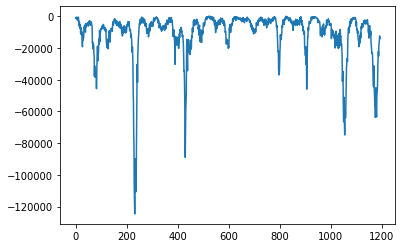

In [7]:
s=10
r=28
L = df.iloc[:, 2] + df.iloc[:, 1]*(1 + s) - df.iloc[:, 0] * s * (r - 1)
L.plot()

## Preprocessing the data into supervised learning

In [8]:
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg    

In [9]:
dat = Supervised(df.values, n_in = 10, n_out = 52)
dat.columns

Index(['var1(t-10)', 'var2(t-10)', 'var3(t-10)', 'var1(t-9)', 'var2(t-9)',
       'var3(t-9)', 'var1(t-8)', 'var2(t-8)', 'var3(t-8)', 'var1(t-7)',
       ...
       'var3(t+48)', 'var1(t+49)', 'var2(t+49)', 'var3(t+49)', 'var1(t+50)',
       'var2(t+50)', 'var3(t+50)', 'var1(t+51)', 'var2(t+51)', 'var3(t+51)'],
      dtype='object', length=186)

In [10]:
data = Supervised(df.values, n_in = 10, n_out = 52)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
       'var3(t-2)', 'var2(t-1)', 'var3(t-1)','var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)#,18,19
print(data.head())
print(data.columns)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10         4.0        5.0        4.0        3.0        6.0        2.0   
11         5.0        4.0        3.0        6.0        2.0        4.0   
12         4.0        3.0        6.0        2.0        4.0        5.0   
13         3.0        6.0        2.0        4.0        5.0       10.0   
14         6.0        2.0        4.0        5.0       10.0        6.0   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  ...  var3(t+48)  var1(t+49)  \
10        4.0        5.0       10.0        6.0  ...    0.224490        14.0   
11        5.0       10.0        6.0        8.0  ...   -0.183673        18.0   
12       10.0        6.0        8.0        2.0  ...    0.122449        13.0   
13        6.0        8.0        2.0        6.0  ...    0.061224        14.0   
14        8.0        2.0        6.0       17.0  ...    0.020408        18.0   

    var2(t+49)  var3(t+49)  var1(t+50)  var2(t+50)  var3(t+50)  var1(t+51)  \
10    0.

## Train and Test Split

In [11]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_1 = np.array(data[0:train_size])
test_1 = np.array(data[train_size:len(data)])
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train_1)
test = scaler.transform(test_1)
trainY = train[:,-9:]
trainX = train[:,:-9]
testY = test[:,-9:]
testX = test[:,:-9]
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(906, 1, 157) (906, 9) (227, 1, 157) (227, 9)


## Defining the Physical Loss

In [12]:
s = tf.Variable(10, name="sigma", trainable=True, dtype=tf.float32)
r = tf.Variable(28, name="rhow", trainable=True, dtype=tf.float32)


def phys(y_pred, y_true):
    return mean_absolute_error((y_true[:, 2] + y_true[:, 1]*(1 + s) - y_true[:, 0] * s * (r - 1)), (y_pred[:, 2] + y_pred[:, 1]*(1 + s) - y_pred[:, 0] * s * (r - 1)))

def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] + (y_pred[1:-1]-y_pred[:-2])*(1 + s) - y_pred[:-2] * s * (r - 1)
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] + (y_real[1:-1]-y_real[:-2])*(1 + s) - y_real[:-2] * s * (r - 1)
    return(mean_absolute_error(pred, real))

## Model

In [13]:
s = tf.Variable(10, name="sigma", trainable=True, dtype=tf.float32)
r = tf.Variable(28, name="rhow", trainable=True, dtype=tf.float32)

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square((y_pred[:, 2] + y_pred[:, 1]*(1 + s) - y_pred[:, 0] * s * (r - 1)))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(9))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False)

Epoch 1/500
15/15 [==============================] - 2s 34ms/step - loss: 41.2996 - val_loss: 24.3478
Epoch 2/500
15/15 [==============================] - 0s 4ms/step - loss: 10.0743 - val_loss: 6.6293
Epoch 3/500
15/15 [==============================] - 0s 4ms/step - loss: 3.6706 - val_loss: 4.5244
Epoch 4/500
15/15 [==============================] - 0s 4ms/step - loss: 2.9154 - val_loss: 3.3247
Epoch 5/500
15/15 [==============================] - 0s 3ms/step - loss: 2.2187 - val_loss: 2.7500
Epoch 6/500
15/15 [==============================] - 0s 4ms/step - loss: 1.8704 - val_loss: 2.3656
Epoch 7/500
15/15 [==============================] - 0s 4ms/step - loss: 1.6142 - val_loss: 2.0255
Epoch 8/500
15/15 [==============================] - 0s 4ms/step - loss: 1.3848 - val_loss: 1.7496
Epoch 9/500
15/15 [==============================] - 0s 3ms/step - loss: 1.1893 - val_loss: 1.5174
Epoch 10/500
15/15 [==============================] - 0s 5ms/step - loss: 1.0299 - val_loss: 1.3272
Epoch

## Metrics

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

8/8 [==============================] - 0s 1ms/step
(227, 9)
(227, 157)
Test RMSE: 86.597
Test MAE: 58.185
